In [1]:
"The goal of the exercise is to get comfortable with different types of missingness and ways to " \
"try and handle them with a few basic imputation methods using numpy, pandas, and sklearn. The " \
"examples will show how the combination of different types of missingness and imputation methods " \
"can affect inference."

'The goal of the exercise is to get comfortable with different types of missingness and ways to try and handle them with a few basic imputation methods using numpy, pandas, and sklearn. The examples will show how the combination of different types of missingness and imputation methods can affect inference.'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression 
from sklearn.impute import SimpleImputer, KNNImputer

In [3]:
# Number of data points to generate
n = 500
# Set random seed for numpy to ensure reproducible results
np.random.seed(109)
# Generate our predictors...
x1 = np.random.normal(0, 1, size=n)
x2 = 0.5*x1 + np.random.normal(0, np.sqrt(0.75), size=n)
X = pd.DataFrame(data=np.transpose([x1,x2]),columns=["x1","x2"])
# Generate our response...
y = 3*x1 - 2*x2 + np.random.normal(0, 1, size=n)
y = pd.Series(y)
# And put them all in a nice DataFrame
df = pd.DataFrame(data=np.transpose([x1, x2, y]), columns=["x1", "x2", "y"]) 

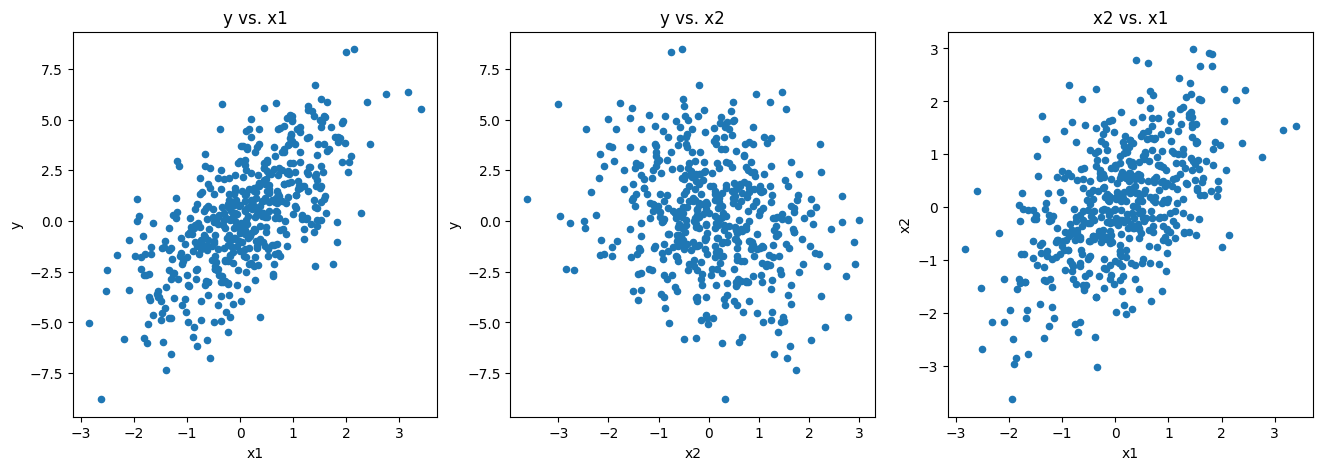

In [4]:
fig, axs =  plt.subplots(1, 3, figsize = (16,5))

plot_pairs = [('x1', 'y'), ('x2', 'y'), ('x1', 'x2')]
for ax, (x_var, y_var) in zip(axs, plot_pairs):
    df.plot.scatter(x_var, y_var, ax=ax, title=f'{y_var} vs. {x_var}')

In [5]:
missing_A = np.random.binomial(1, 0.05 + 0.85*(y > (y.mean()+y.std())),  n).astype(bool)
missing_B = np.random.binomial(1, 0.2, n).astype(bool)
missing_C = np.random.binomial(1, 0.05 + 0.85*(x2 > (x2.mean()+x2.std())), n).astype(bool)

In [6]:
# Helper function to replace x_1 with nan at specified indices
def create_missing(missing_indices, df=df):
    df_new = df.copy()
    df_new.loc[missing_indices, 'x1'] = np.nan
    return df_new

In [7]:
### edTest(test_missing_type) ###

# Missing completely at random (MCAR)
df_mcar = create_missing(missing_indices=missing_B)

# Missing at random (MAR)
df_mar = create_missing(missing_indices=missing_C)

# Missing not at random (MNAR)
df_mnar = create_missing(missing_indices=missing_A)

In [8]:
# no missingness: on the full dataset
ols = LinearRegression().fit(df[['x1', 'x2']], df['y'])
print('No missing data:', ols.intercept_, ols.coef_)

No missing data: 0.10204379528391688 [ 2.92281015 -1.93658251]


In [9]:
# Fit inside a try/except block just in case...
try:
    ouch = LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])
except Exception as e:
    print(e)

Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [10]:
# MCAR: drop the rows that have any missingness
ols_mcar = LinearRegression().fit(df_mcar.dropna()[['x1', 'x2']], df_mcar.dropna()['y'])
print('MCAR (drop):', ols_mcar.intercept_, ols_mcar.coef_)

MCAR (drop): 0.09607569437217288 [ 2.95778269 -1.90922895]


In [11]:
### edTest(test_mar) ###
# MAR: drop the rows that have any missingness
ols_mar = LinearRegression().fit(df_mar.dropna()[['x1', 'x2']], df_mar.dropna()['y'])
print('MAR (drop):', ols_mar.intercept_,ols_mar.coef_)

MAR (drop): 0.1460648111788047 [ 2.93256228 -1.89351279]


In [12]:
# MNAR: drop the rows that have any missingness
ols_mnar = LinearRegression().fit(df_mnar.dropna()[['x1', 'x2']], df_mnar.dropna()['y'])
print('MNAR (drop):', ols_mnar.intercept_, ols_mnar.coef_)

MNAR (drop): 0.020221283325560835 [ 2.77095031 -1.84859735]


In [13]:
# Make backup copies for later since we'll have lots of imputation approaches.
X_mcar_raw = df_mcar.drop('y', axis=1).copy()
X_mar_raw = df_mar.drop('y', axis=1).copy()
X_mnar_raw = df_mnar.drop('y', axis=1).copy()

In [14]:
# Here's an example of one way to do the mean imputation with the above methods
X_mcar = X_mcar_raw.copy()
X_mcar['x1'] = X_mcar['x1'].fillna(X_mcar['x1'].mean())
# Another approach
# df = df.fillna(df.mean)
# This will replace all nans in a df with each column's mean

ols_mcar_mean = LinearRegression().fit(X_mcar, y)
print('MCAR (mean):', ols_mcar_mean.intercept_, ols_mcar_mean.coef_)

MCAR (mean): 0.06518722125657428 [ 2.76751051 -1.56434888]


In [15]:
### edTest(test_mar_mean) ###
X_mar = X_mar_raw.copy()
X_mar['x1'] = X_mar['x1'].fillna(X_mar['x1'].mean())
# You can add as many lines as you see fit, so long as the final model is correct
ols_mar_mean = LinearRegression().fit(X_mar, y)
print('MAR (mean):',ols_mar_mean.intercept_, ols_mar_mean.coef_)

MAR (mean): 0.3922738786668911 [ 2.62546455 -1.22434111]


In [16]:
### edTest(test_mnar_mean) ###
X_mnar = X_mnar_raw.copy()
# instantiate imputer object
imputer = SimpleImputer(strategy='mean')
# fit & transform X_mnar with the imputer
X_mnar = imputer.fit_transform(X_mnar)
# fit OLS model on imputed data
ols_mnar_mean = LinearRegression().fit(X_mnar, y)
print('MNAR (mean):', ols_mnar_mean.intercept_, ols_mnar_mean.coef_)

MNAR (mean): 0.520706160894387 [ 2.64232555 -1.67075578]


In [17]:
X_mcar = X_mcar_raw.copy()

# Fit the imputation model
ols_imputer_mcar = LinearRegression().fit(X_mcar.dropna()[['x2']], X_mcar.dropna()['x1'])

# Perform some imputations
x1hat_impute = pd.Series(ols_imputer_mcar.predict(X_mcar[['x2']]))
X_mcar['x1'] = X_mcar['x1'].fillna(x1hat_impute)

# Fit the model we care about
ols_mcar_ols = LinearRegression().fit(X_mcar, y)
print('MCAR (OLS):', ols_mcar_ols.intercept_,ols_mcar_ols.coef_)

MCAR (OLS): 0.11835122909536368 [ 2.95778269 -1.91346654]


In [18]:
### edTest(test_mar_ols) ###
X_mar = X_mar_raw.copy()
# Fit imputation model
ols_imputer_mar = LinearRegression().fit(X_mar.dropna()[['x2']], X_mar.dropna()['x1'])
# Get values to be imputed
x1hat_impute = pd.Series(ols_imputer_mar.predict(X_mar[['x2']]))
# Fill missing values with imputer's predictions
X_mar['x1'] = X_mar['x1'].fillna(x1hat_impute)
# Fit our final, 'substantive' model
ols_mar_ols = LinearRegression().fit(X_mar, y)

print('MAR (OLS):', ols_mar_ols.intercept_,ols_mar_ols.coef_)

MAR (OLS): 0.007334836526979582 [ 2.93256228 -1.99438598]


In [19]:
### edTest(test_mnar_ols) ###
X_mnar = X_mnar_raw.copy()
# your code here
ols_imputer_mnar = LinearRegression().fit(X_mnar.dropna()[['x2']], X_mnar.dropna()['x1'])
x1hat_impute = pd.Series(ols_imputer_mnar.predict(X_mnar[['x2']]))
X_mnar['x1'] = X_mnar['x1'].fillna(x1hat_impute)
# You can add as many lines as you see fit, so long as the final model is correct
ols_mnar_ols = LinearRegression().fit(X_mnar, y)
print('MNAR (OLS):', ols_mnar_ols.intercept_, ols_mnar_ols.coef_)

MNAR (OLS): 0.6148065869266275 [ 2.77095031 -1.97302957]


In [20]:
X_mcar = X_mcar_raw.copy()

X_mcar = KNNImputer(n_neighbors=3).fit_transform(X_mcar)

ols_mcar_knn = LinearRegression().fit(X_mcar,y)

print('MCAR (KNN):', ols_mcar_knn.intercept_,ols_mcar_knn.coef_)

MCAR (KNN): 0.15134915515799063 [ 2.78459666 -1.85426345]


In [21]:
### edTest(test_mar_knn) ###
X_mar = X_mar_raw.copy()
# Add imputed values to X_mar
X_mar = KNNImputer(n_neighbors=3).fit_transform(X_mar)
# Fit substantive model on imputed data
ols_mar_knn = LinearRegression().fit(X_mar, y)

print('MAR (KNN):', ols_mar_knn.intercept_,ols_mar_knn.coef_)

MAR (KNN): 0.24560978941317943 [ 2.72661518 -1.55667191]


In [22]:
### edTest(test_mnar_knn) ###
X_mnar = X_mnar_raw.copy()
# your code here
X_mnar = KNNImputer(n_neighbors=3).fit_transform(X_mnar)
# You can add as many lines as you see fit, so long as the final model is correct
ols_mnar_knn = LinearRegression().fit(X_mnar, y)

print('MNAR (KNN):', ols_mnar_knn.intercept_,ols_mnar_knn.coef_)

MNAR (KNN): 0.6358511234519549 [ 2.62065071 -1.93067768]
